### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import antropy as ant
import spkit as sp
import seaborn as sns
sns.set()
import EntropyHub as En
from sklearn.preprocessing import MinMaxScaler

import warnings
from vmdpy import VMD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV


### Read and preprocess data

In [2]:
# import data

EEG_129_CH2 = pd.read_csv('EEG_129_CH2.csv')
bis_129 = pd.read_csv('bis_129.csv')
B129=bis_129['BIS/BIS']
E129=EEG_129_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 129 is {} and {} '.format(E129.shape,B129.shape) )

The shape of EEG signals and BIS for patient 129 is (985010,) and (7674,) 


In [3]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E129)

Missing Values:
Total Missing Values: 2834
Percentage of Missing Values: 0.28771281509832386 %


In [4]:
E129_copy = np.copy(E129)

In [5]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
handle_missing_values(E129_copy)

array([-33.55, -33.55, -33.55, ...,  25.5 ,  25.5 ,  25.5 ])

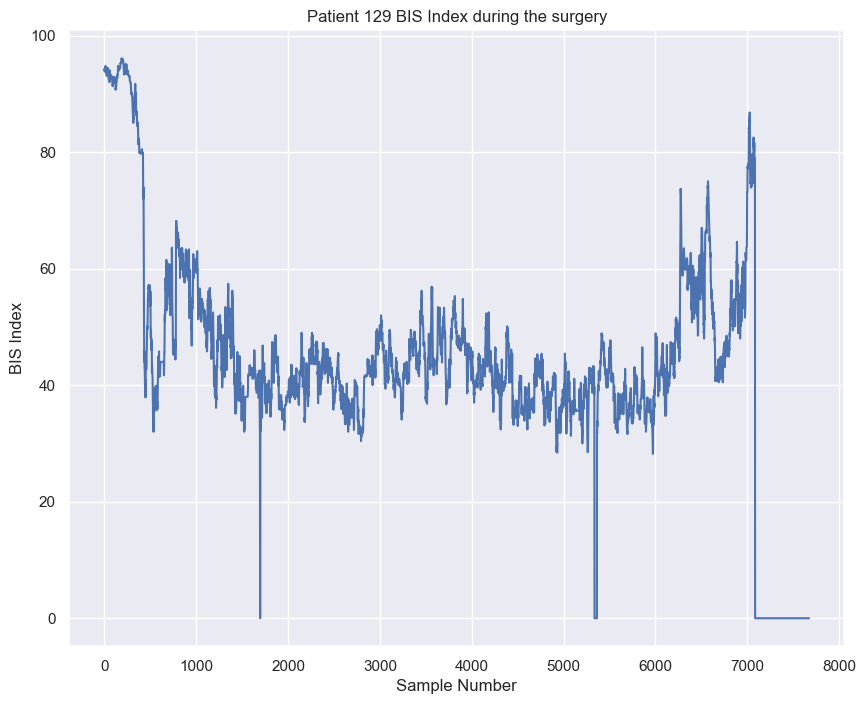

In [6]:
# Patient 129 BIS values throughout the surgery
fig = plt.figure(figsize=(10, 8))
plt.plot(B129)
plt.xlabel("Sample Number")
plt.ylabel("BIS Index")
plt.title("Patient 129 BIS Index during the surgery")
plt.show()

### Selecting EEG signals

In [7]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B129
EEG = E129_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 0
bis_end_index = 7080

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[60:2355]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-33.55 -33.55 -33.55 ...   7.65  14.8   18.2 ]


Number of BIS before windowing: 7080


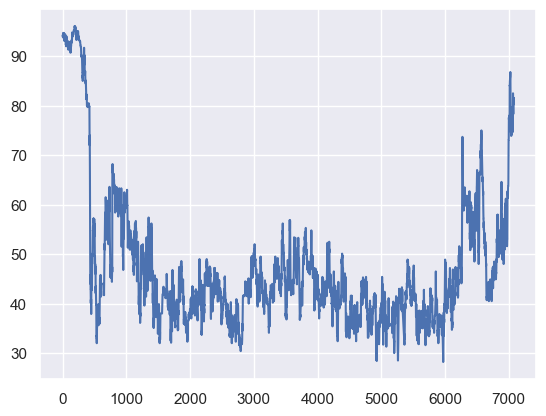

In [8]:
# Replacing the zero values in BIS
from scipy.interpolate import interp1d

def replace_zeroes_with_interpolation(series):
    # Find indices and values of non-zero elements
    non_zero_indices = [i for i, val in enumerate(series) if val != 0]
    non_zero_values = [series[i] for i in non_zero_indices]

    # Create an interpolation function using scipy's interp1d
    interpolation_function = interp1d(non_zero_indices, non_zero_values, kind='linear', bounds_error=False, fill_value="extrapolate")

    # Replace zeroes with interpolated values
    new_series = [interpolation_function(i) if val == 0 else val for i, val in enumerate(series)]

    return new_series

# Test the function
series = selected_bis
new_bis = replace_zeroes_with_interpolation(series)
plt.plot(new_bis)
print("Number of BIS before windowing:", len(new_bis))

In [9]:
#bandpass filter

# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the frequency bands
low = 0.01
high = 63.5
fs=128

# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply bandpass filters to the EEG signal
  
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs)



# Plot the original and filtered signals
time = np.arange(len(eeg_signal)) / fs

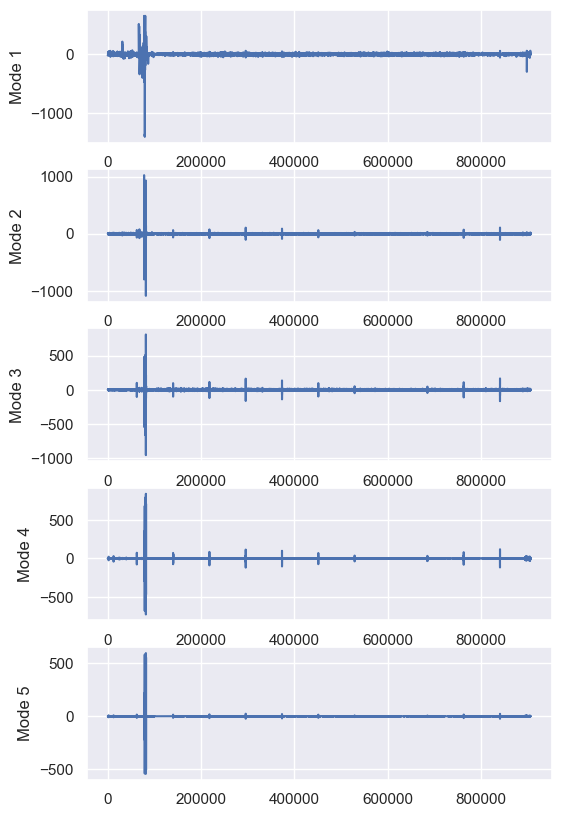

In [10]:
import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 2000
tau = 0.5
K = 5
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes

fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

### Save the modes in csv

np.savetxt("modes0.csv", modes[0], delimiter=",", header="modes0")
np.savetxt("modes1.csv", modes[1], delimiter=",", header="modes1")
np.savetxt("modes2.csv", modes[2], delimiter=",", header="modes2")
np.savetxt("modes3.csv", modes[3], delimiter=",", header="modes3")
np.savetxt("modes4.csv", modes[4], delimiter=",", header="modes4")

Number of BIS: 7025


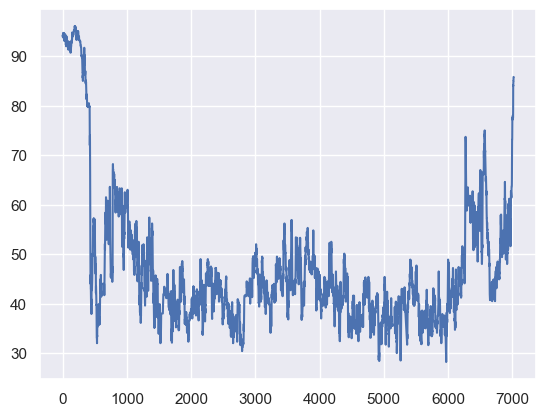

In [11]:
# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = new_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [12]:
#### For entropies

def moving_sliding_window(data, method, window_size_sec=56, overlap_sec=55, sampling_rate=128):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        
        if method == "sample entropy":
            # Calculate sample entropy within the window
            embedding_dimension = 2
            tolerance = 0.2
            sample_entropy = sampen(window, emb_dim=embedding_dimension, tolerance=tolerance)
            result.append(sample_entropy)
    
            
        if method == "spectral entropy":
            # Calculate sample entropy within the window
            sf=128
            spectral_entropy = ant.spectral_entropy(window, sf)
            result.append(spectral_entropy)
            
            
        if method == "lzc":
            # Calculate sample entropy within the window
            lzc_entropy = ant.lziv_complexity(window)
            result.append(lzc_entropy)
            
        if method == "svd":
            # Calculate sample entropy within the window
            svd_entropy = ant.svd_entropy(window)
            result.append(svd_entropy)
            
        if method == "dispm":
            # Calculate dispersion_entropy_multiscale_refined within the window
            disp_m, prob = sp.dispersion_entropy_multiscale_refined(window,classes=2, emb_dim=3, delay=1,return_all=False)
            result.append(disp_m)

        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            #Dispersion_entropy, prob =En.DispEn(window,classes=2, scale=3, emb_dim=8, delay=2,return_all=False)
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=2, scale=4, emb_dim=3, delay=1,return_all=False)
            result.append(Dispersion_entropy)
            
        if method == "fuzzy":
            # Calculate sample entropy within the window
            Fuzzy_entropy, prob =En.FuzzEn(window, m=3, r=0.5, Fx='gudermannian')
            #Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=5, delay=1,return_all=False)
            result.append(Fuzzy_entropy)
        
         # Detrended Fluctuation
        if method == "detf":
            detf = ant.detrended_fluctuation(window)
            result.append(detf)
            
             # Petrosian
        if method == "pet":
            pet = ant.petrosian_fd(window)
            result.append(pet)
            
            
             # hjorth-mobility
        if method == "hm":
            hm = ant.hjorth_params(window)[0]
            result.append(hm)
            
             # hjorth-complex
        if method == "hc":
            hc = ant.hjorth_params(window)[1]
            result.append(hc)
            
            # Higuchi Fractal Dimension
        if method == "hfd":
            hfd = ant.higuchi_fd(window)
            result.append(hfd)
          
            # # Katz Fractal Dimension
        if method == "kfd":
            kfd = ant.katz_fd(window)
            result.append(kfd)
            
    
        
    return result


In [13]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 7025


Number of features: 7025


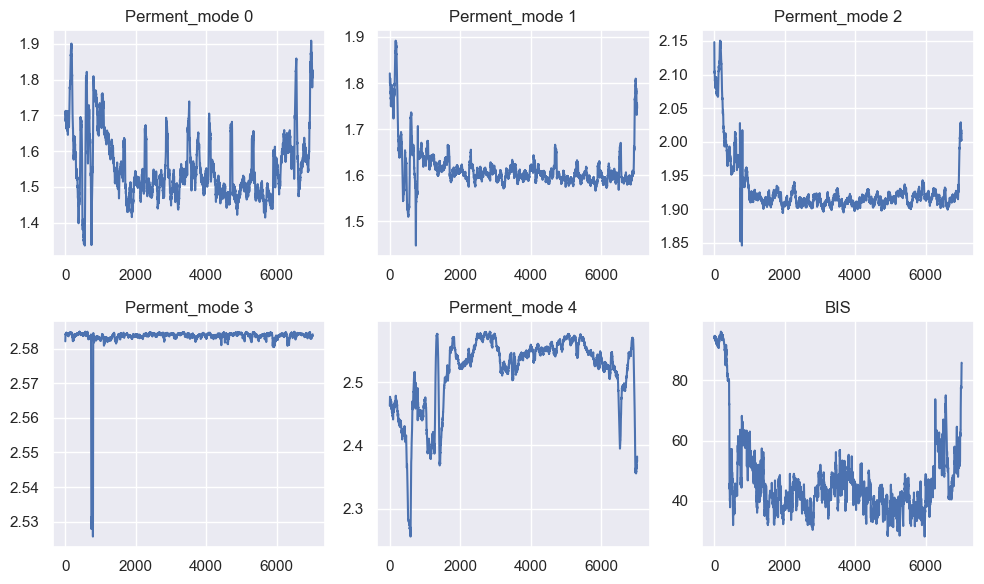

In [14]:
print(f"Number of features:", len(resultsp_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsp_0)
axes[0, 0].set_title('Perment_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsp_1)
axes[0, 1].set_title('Perment_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsp_2)
axes[0, 2].set_title('Perment_mode 2')

axes[1, 0].plot(resultsp_3)
axes[1, 0].set_title('Perment_mode 3')

axes[1, 1].plot(resultsp_4)
axes[1, 1].set_title('Perment_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()



In [15]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultspet_0 = moving_sliding_window(data0, method='pet')
resultspet_1 = moving_sliding_window(data1, method='pet')
resultspet_2 = moving_sliding_window(data2, method='pet')
resultspet_3 = moving_sliding_window(data3, method='pet')
resultspet_4 = moving_sliding_window(data4, method='pet')
print(f"Number of features:", len(resultspet_0))

Number of features: 7025


Number of features: 7025


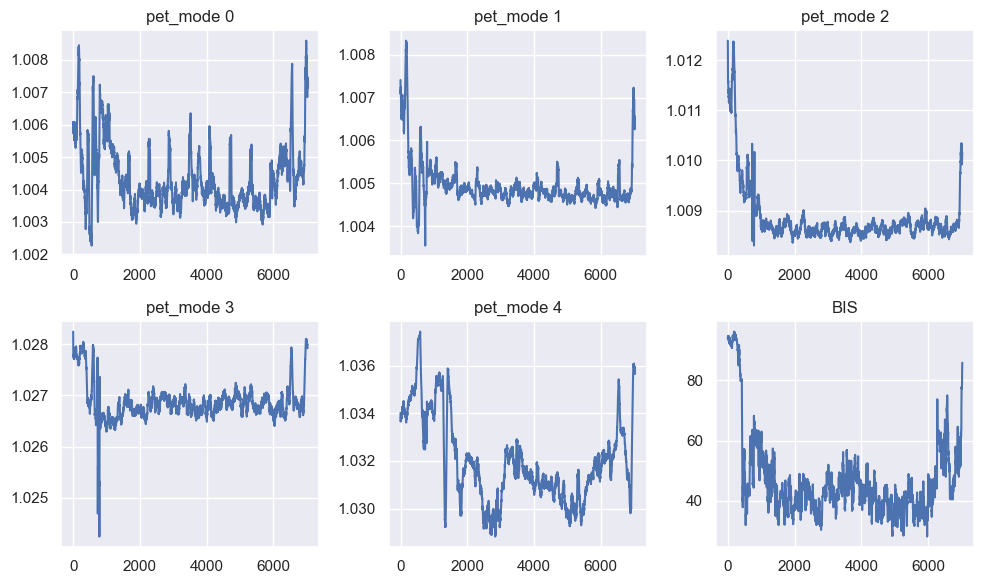

In [16]:
print(f"Number of features:", len(resultspet_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspet_0)
axes[0, 0].set_title('pet_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspet_1)
axes[0, 1].set_title('pet_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspet_2)
axes[0, 2].set_title('pet_mode 2')

axes[1, 0].plot(resultspet_3)
axes[1, 0].set_title('pet_mode 3')

axes[1, 1].plot(resultspet_4)
axes[1, 1].set_title('pet_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [17]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultshc_0 = moving_sliding_window(data0, method='hc')
resultshc_1 = moving_sliding_window(data1, method='hc')
resultshc_2 = moving_sliding_window(data2, method='hc')
resultshc_3 = moving_sliding_window(data3, method='hc')
resultshc_4 = moving_sliding_window(data4, method='hc')
print(f"Number of features:", len(resultshc_0))

Number of features: 7025


Number of features: 7025


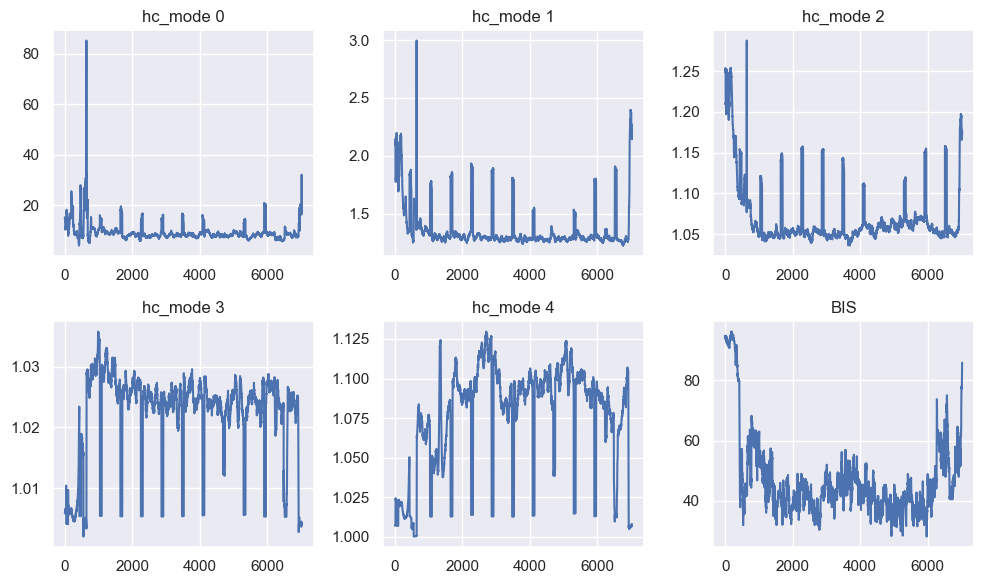

In [18]:
print(f"Number of features:", len(resultshc_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshc_0)
axes[0, 0].set_title('hc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshc_1)
axes[0, 1].set_title('hc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshc_2)
axes[0, 2].set_title('hc_mode 2')

axes[1, 0].plot(resultshc_3)
axes[1, 0].set_title('hc_mode 3')

axes[1, 1].plot(resultshc_4)
axes[1, 1].set_title('hc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [19]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultshm_0 = moving_sliding_window(data0,  method='hm')
resultshm_1 = moving_sliding_window(data1, method='hm')
resultshm_2 = moving_sliding_window(data2, method='hm')
resultshm_3 = moving_sliding_window(data3, method='hm')
resultshm_4 = moving_sliding_window(data4, method='hm')
print(f"Number of features:", len(resultshm_0))

Number of features: 7025


Number of features: 7025


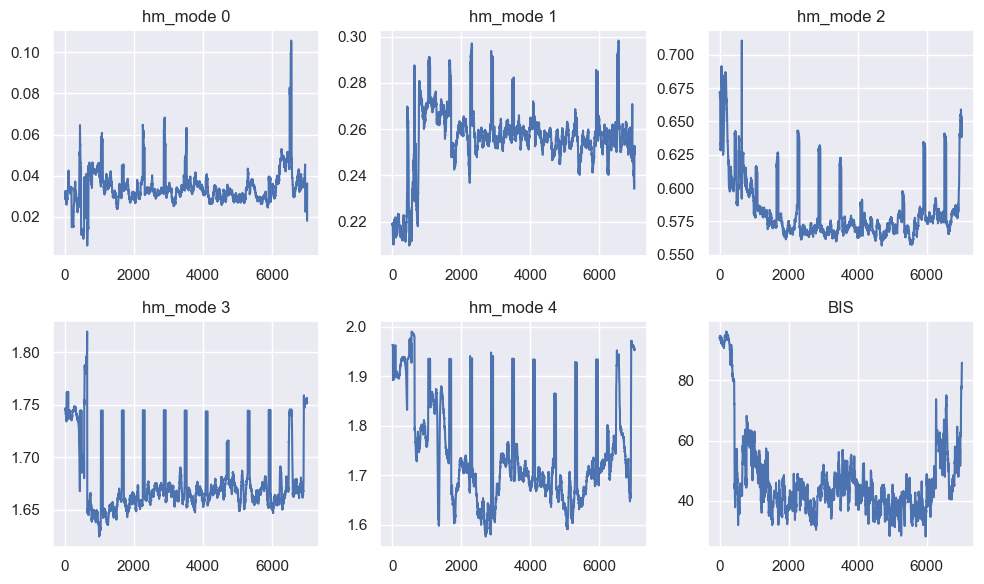

In [20]:
print(f"Number of features:", len(resultshm_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshm_0)
axes[0, 0].set_title('hm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshm_1)
axes[0, 1].set_title('hm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshm_2)
axes[0, 2].set_title('hm_mode 2')

axes[1, 0].plot(resultshm_3)
axes[1, 0].set_title('hm_mode 3')

axes[1, 1].plot(resultshm_4)
axes[1, 1].set_title('hm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [21]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultslzc_0 = moving_sliding_window(data0, method='lzc')
resultslzc_1 = moving_sliding_window(data1, method='lzc')
resultslzc_2 = moving_sliding_window(data2, method='lzc')
resultslzc_3 = moving_sliding_window(data3, method='lzc')
resultslzc_4 = moving_sliding_window(data4, method='lzc')
print(f"Number of features:", len(resultslzc_1))

Number of features: 7025


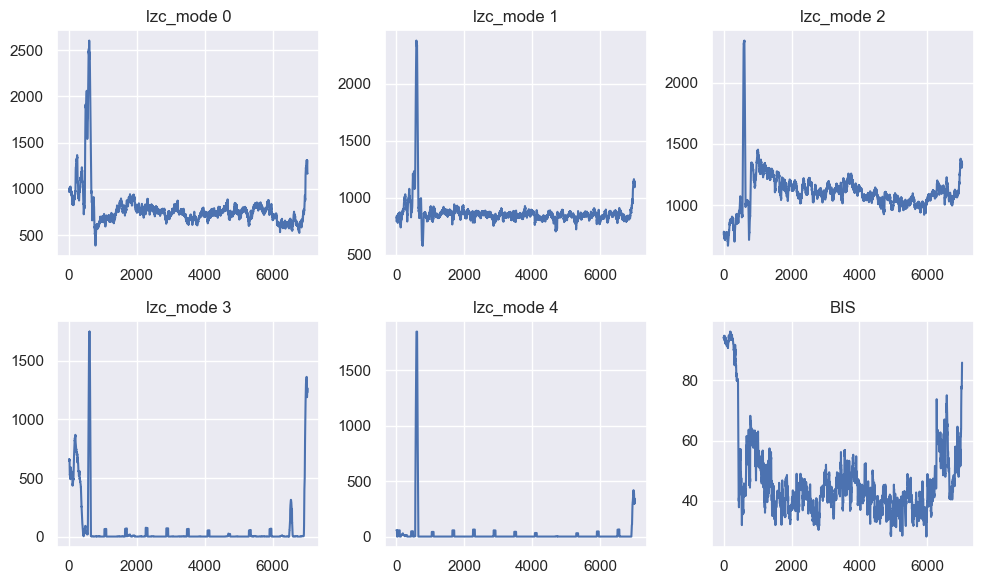

In [22]:
# Lzc


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultslzc_0)
axes[0, 0].set_title('lzc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultslzc_1)
axes[0, 1].set_title('lzc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultslzc_2)
axes[0, 2].set_title('lzc_mode 2')

axes[1, 0].plot(resultslzc_3)
axes[1, 0].set_title('lzc_mode 3')

axes[1, 1].plot(resultslzc_4)
axes[1, 1].set_title('lzc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()

ant.higuchi_fd

# Display the figure
plt.show()

In [23]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]



resultspec_0 = moving_sliding_window(data0, method='spectral entropy')
resultspec_1 = moving_sliding_window(data1, method='spectral entropy')
resultspec_2 = moving_sliding_window(data2, method='spectral entropy')
resultspec_3 = moving_sliding_window(data3, method='spectral entropy')
resultspec_4 = moving_sliding_window(data4, method='spectral entropy')
print(f"Number of features:", len(resultspec_1))

Number of features: 7025


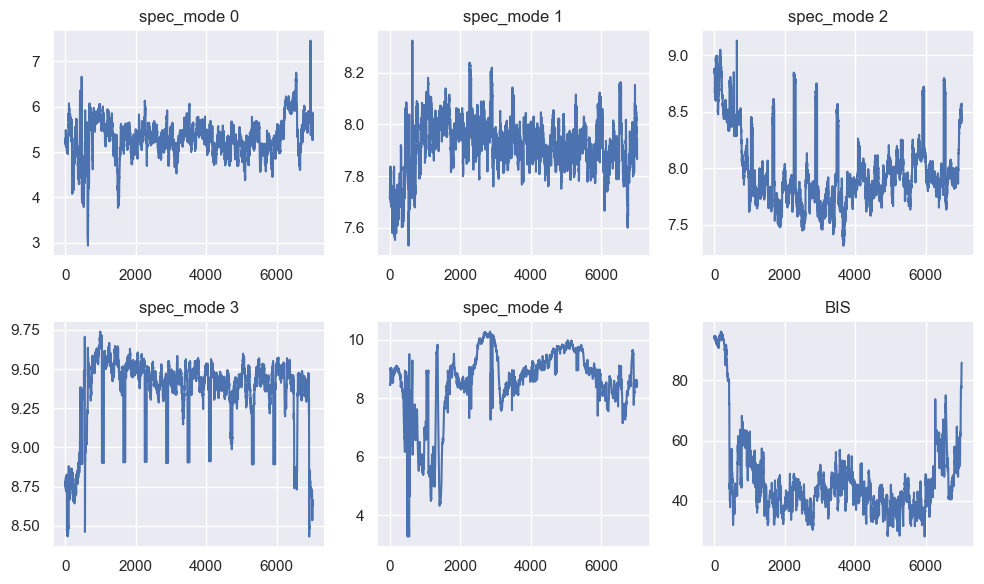

In [24]:
# spectral entropy


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspec_0)
axes[0, 0].set_title('spec_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspec_1)
axes[0, 1].set_title('spec_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspec_2)
axes[0, 2].set_title('spec_mode 2')

axes[1, 0].plot(resultspec_3)
axes[1, 0].set_title('spec_mode 3')

axes[1, 1].plot(resultspec_4)
axes[1, 1].set_title('spec_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [25]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsdispm_0 = moving_sliding_window(data0, method='dispm')
resultsdispm_1 = moving_sliding_window(data1, method='dispm')
resultsdispm_2 = moving_sliding_window(data2, method='dispm')
resultsdispm_3 = moving_sliding_window(data3, method='dispm')
resultsdispm_4 = moving_sliding_window(data4, method='dispm')
print(f"Number of features:", len(resultsdispm_1))

Number of features: 7025


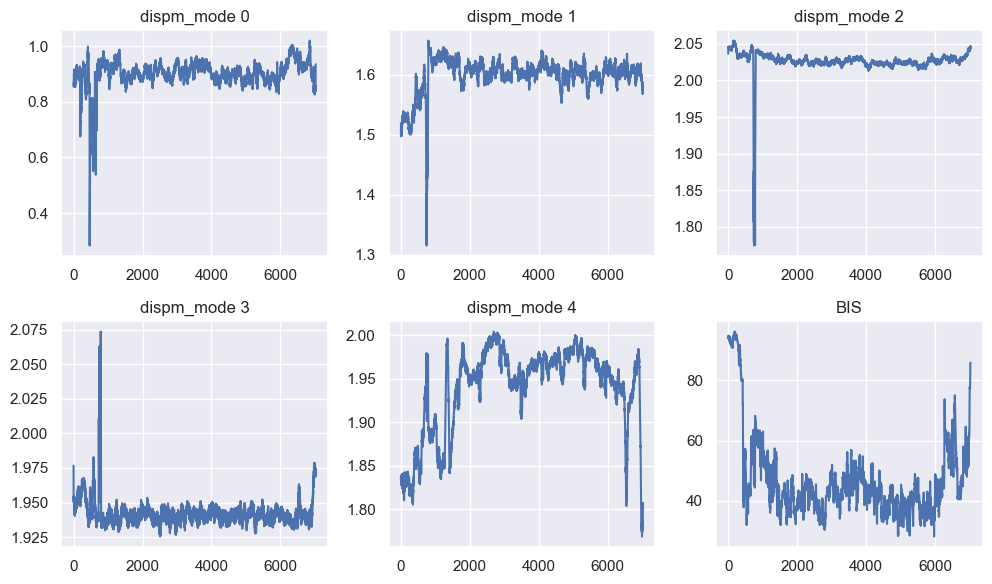

In [26]:
# dispm


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsdispm_0)
axes[0, 0].set_title('dispm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsdispm_1)
axes[0, 1].set_title('dispm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsdispm_2)
axes[0, 2].set_title('dispm_mode 2')

axes[1, 0].plot(resultsdispm_3)
axes[1, 0].set_title('dispm_mode 3')

axes[1, 1].plot(resultsdispm_4)
axes[1, 1].set_title('dispm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [27]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 7025


Number of features: 7025


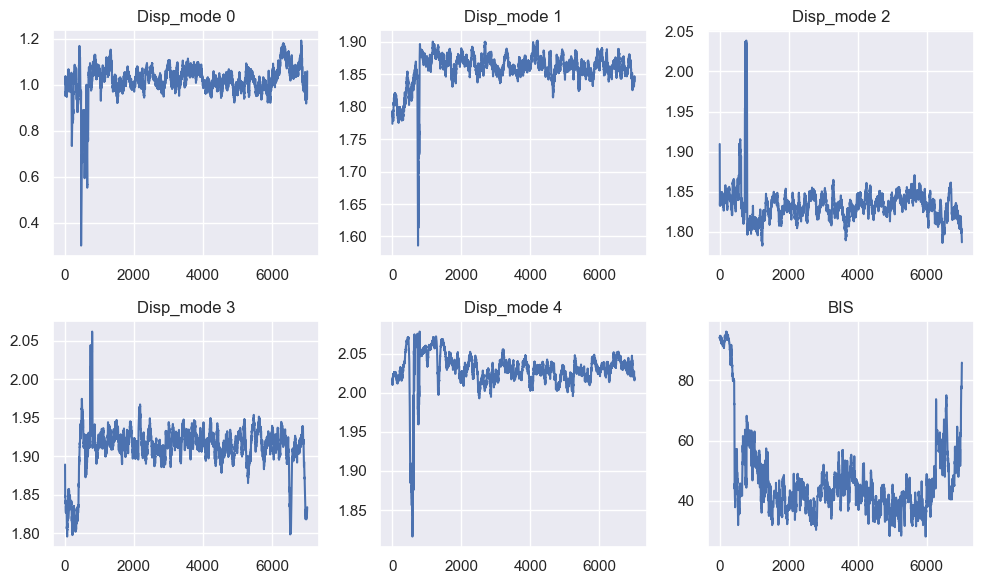

In [28]:
print(f"Number of features:", len(resultsd_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsd_0)
axes[0, 0].set_title('Disp_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsd_1)
axes[0, 1].set_title('Disp_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsd_2)
axes[0, 2].set_title('Disp_mode 2')

axes[1, 0].plot(resultsd_3)
axes[1, 0].set_title('Disp_mode 3')

axes[1, 1].plot(resultsd_4)
axes[1, 1].set_title('Disp_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [29]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultsvd_0 = moving_sliding_window(data0, method='svd')
resultsvd_1 = moving_sliding_window(data1, method='svd')
resultsvd_2 = moving_sliding_window(data2, method='svd')
resultsvd_3 = moving_sliding_window(data3, method='svd')
resultsvd_4 = moving_sliding_window(data4, method='svd')
print(f"Number of features:", len(resultsvd_1))

Number of features: 7025


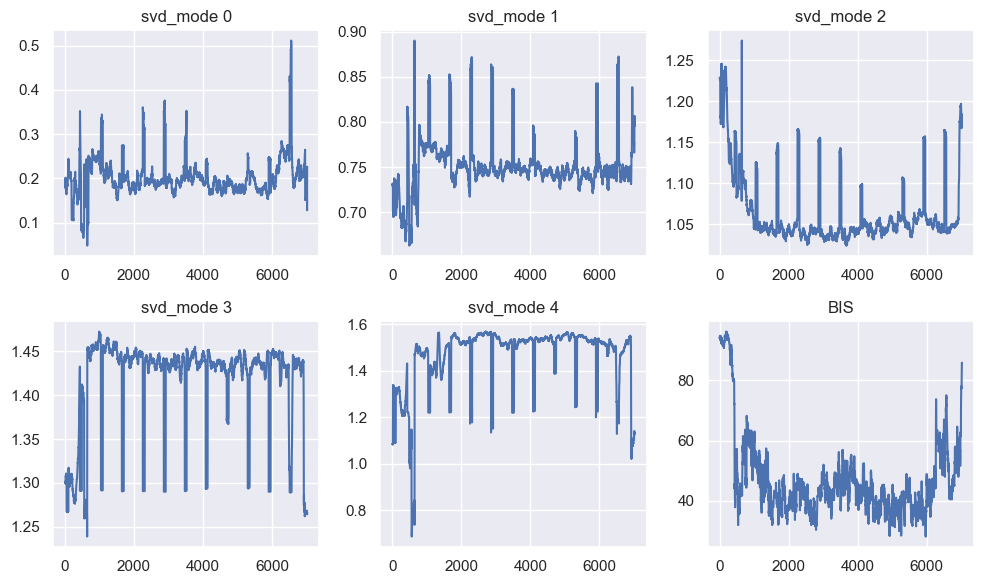

In [30]:
# svd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsvd_0)
axes[0, 0].set_title('svd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsvd_1)
axes[0, 1].set_title('svd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsvd_2)
axes[0, 2].set_title('svd_mode 2')

axes[1, 0].plot(resultsvd_3)
axes[1, 0].set_title('svd_mode 3')

axes[1, 1].plot(resultsvd_4)
axes[1, 1].set_title('svd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [31]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultshfd_0 = moving_sliding_window(data0, method='hfd')
resultshfd_1 = moving_sliding_window(data1, method='hfd')
resultshfd_2 = moving_sliding_window(data2, method='hfd')
resultshfd_3 = moving_sliding_window(data3, method='hfd')
resultshfd_4 = moving_sliding_window(data4, method='hfd')
print(f"Number of features:", len(resultshfd_0))

Number of features: 7025


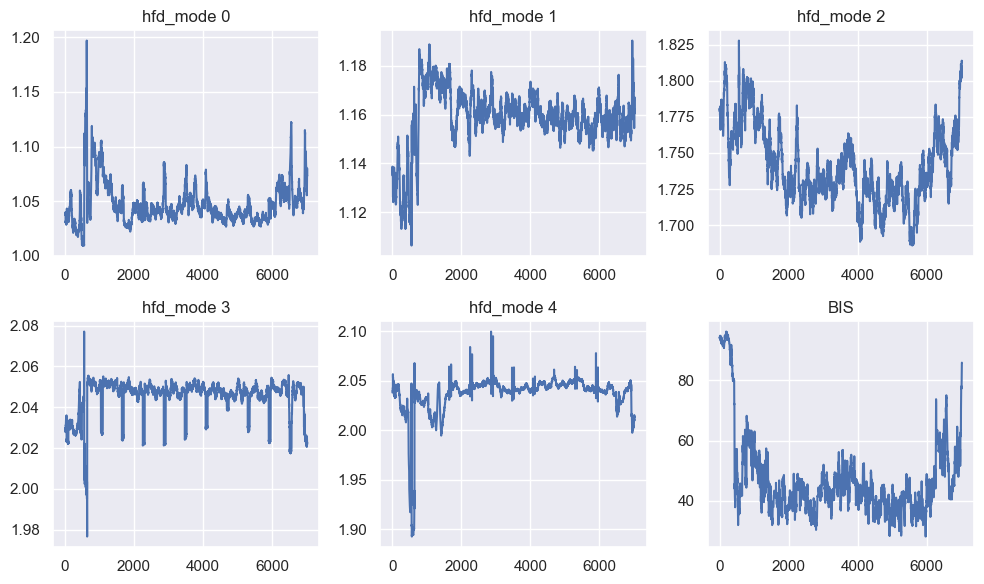

In [32]:
# hfd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshfd_0)
axes[0, 0].set_title('hfd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshfd_1)
axes[0, 1].set_title('hfd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshfd_2)
axes[0, 2].set_title('hfd_mode 2')

axes[1, 0].plot(resultshfd_3)
axes[1, 0].set_title('hfd_mode 3')

axes[1, 1].plot(resultshfd_4)
axes[1, 1].set_title('hfd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

In [33]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultsdt_0 = moving_sliding_window(data0, method='detf')
resultsdt_1 = moving_sliding_window(data1, method='detf')
resultsdt_2 = moving_sliding_window(data2, method='detf')
resultsdt_3 = moving_sliding_window(data3, method='detf')
resultsdt_4 = moving_sliding_window(data4, method='detf')
print(f"Number of features:", len(resultsdt_0))

Number of features: 7025


Number of features: 7025


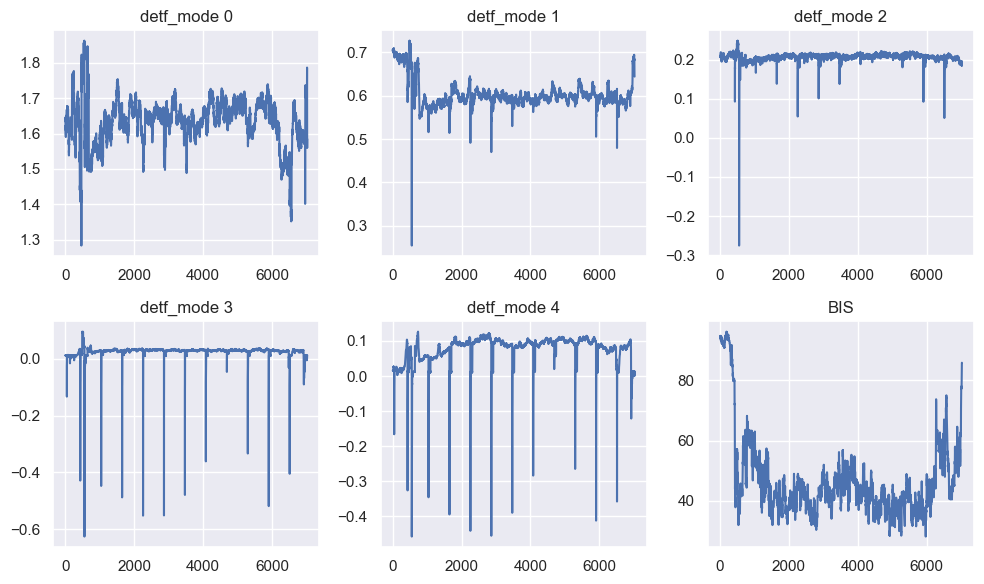

In [34]:
print(f"Number of features:", len(resultsdt_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsdt_0)
axes[0, 0].set_title('detf_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsdt_1)
axes[0, 1].set_title('detf_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsdt_2)
axes[0, 2].set_title('detf_mode 2')

axes[1, 0].plot(resultsdt_3)
axes[1, 0].set_title('detf_mode 3')

axes[1, 1].plot(resultsdt_4)
axes[1, 1].set_title('detf_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


In [35]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]


resultskfd_0 = moving_sliding_window(data0, method='kfd')
resultskfd_1 = moving_sliding_window(data1, method='kfd')
resultskfd_2 = moving_sliding_window(data2, method='kfd')
resultskfd_3 = moving_sliding_window(data3, method='kfd')
resultskfd_4 = moving_sliding_window(data4, method='kfd')
print(f"Number of features:", len(resultskfd_1))

Number of features: 7025


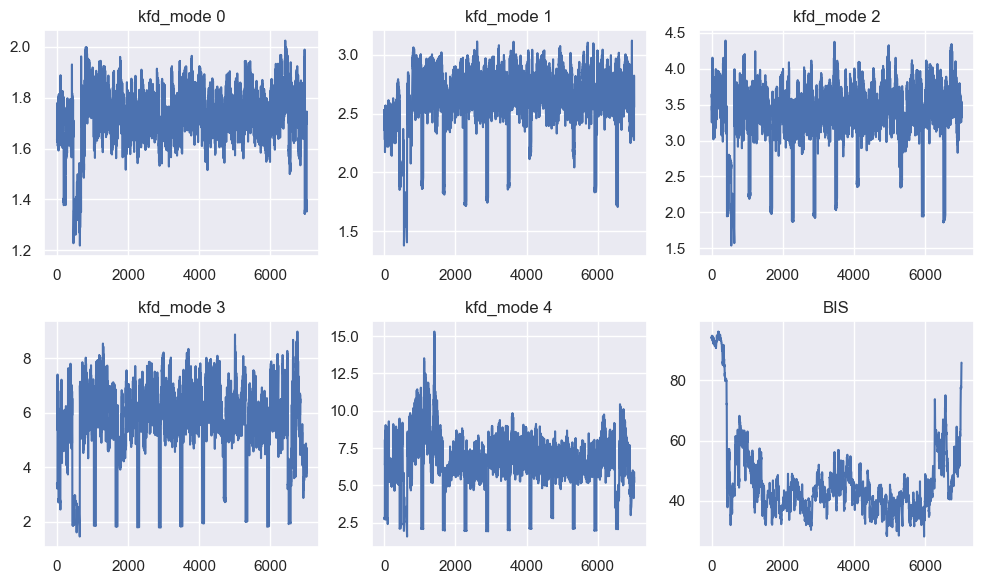

In [36]:
# kfd


# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultskfd_0)
axes[0, 0].set_title('kfd_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultskfd_1)
axes[0, 1].set_title('kfd_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultskfd_2)
axes[0, 2].set_title('kfd_mode 2')

axes[1, 0].plot(resultskfd_3)
axes[1, 0].set_title('kfd_mode 3')

axes[1, 1].plot(resultskfd_4)
axes[1, 1].set_title('kfd_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()

### Create Dataframe for each feature

In [37]:
# kfd

df_kfd = pd.DataFrame({'kfd_mode0': resultskfd_0, 'kfd_mode1': resultskfd_1, 'kfd_mode2': resultskfd_2, 'kfd_mode3': resultskfd_3, 'kfd_mode4': resultskfd_4})

df_kfd['BIS']=bis_windows


In [38]:
# detf

df_detf = pd.DataFrame({'detf_mode0': resultsdt_0, 'detf_mode1': resultsdt_1, 'detf_mode2': resultsdt_2, 'detf_mode3': resultsdt_3, 'detf_mode4': resultsdt_4})

df_detf['BIS']=bis_windows
#df_detf


In [39]:
# dispm

df_dispm = pd.DataFrame({'dispm_mode0': resultsdispm_0, 'dispm_mode1': resultsdispm_1, 'dispm_mode2': resultsdispm_2, 'dispm_mode3': resultsdispm_3, 'dispm_mode4': resultsdispm_4})

df_dispm['BIS']=bis_windows
df_dispm

,dispm_mode0,dispm_mode1,dispm_mode2,dispm_mode3,dispm_mode4,BIS
0,0.869572,1.497408,2.036672,1.976740,1.832678,94.0
1,0.866911,1.506559,2.043749,1.961236,1.837349,94.3
2,0.866782,1.513786,2.044897,1.954698,1.836600,94.1
3,0.863646,1.519575,2.045826,1.952196,1.833150,93.8
4,0.864351,1.515365,2.045495,1.954429,1.836419,93.8
...,...,...,...,...,...,...
7020,0.920494,1.587553,2.046678,1.971859,1.795055,85.0
7021,0.912595,1.580294,2.045408,1.971271,1.801619,85.0
7022,0.908642,1.583605,2.043573,1.972293,1.802334,85.8
7023,0.928979,1.582702,2.046561,1.971555,1.802633,85.8


In [40]:
# pet

df_pet = pd.DataFrame({'pet_mode0': resultspet_0, 'pet_mode1': resultspet_1, 'pet_mode2': resultspet_2, 'pet_mode3': resultspet_3, 'pet_mode4': resultspet_4})

df_pet['BIS']=bis_windows
#df_pet

In [41]:
# hm

df_hm = pd.DataFrame({'hm_mode0': resultshm_0, 'hm_mode1': resultshm_1, 'hm_mode2': resultshm_2, 'hm_mode3': resultshm_3, 'hm_mode4': resultshm_4})

df_hm['BIS']=bis_windows
#df_hm


In [42]:
# hc

df_hc = pd.DataFrame({'hc_mode0': resultshc_0, 'hc_mode1': resultshc_1, 'hc_mode2': resultshc_2, 'hc_mode3': resultshc_3, 'hc_mode4': resultshc_4})

df_hc['BIS']=bis_windows
#df_hc


In [43]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
#df_perm

In [44]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
#df_disp

In [45]:
# hfd

df_hfd = pd.DataFrame({'hfd_mode0': resultshfd_0, 'hfd_mode1': resultshfd_1, 'hfd_mode2': resultshfd_2, 'hfd_mode3': resultshfd_3, 'hfd_mode4': resultshfd_4})

df_hfd['BIS']=bis_windows
df_hfd

,hfd_mode0,hfd_mode1,hfd_mode2,hfd_mode3,hfd_mode4,BIS
0,1.037936,1.136906,1.780061,2.029129,2.038106,94.0
1,1.038555,1.137619,1.781061,2.029210,2.038771,94.3
2,1.038197,1.137339,1.780841,2.028697,2.038467,94.1
3,1.038413,1.138657,1.780355,2.029958,2.038338,93.8
4,1.038615,1.136335,1.778591,2.029298,2.038943,93.8
...,...,...,...,...,...,...
7020,1.077898,1.165808,1.812961,2.021769,2.011471,85.0
7021,1.080004,1.167144,1.814040,2.022181,2.011933,85.0
7022,1.075214,1.164661,1.813059,2.022518,2.011277,85.8
7023,1.073004,1.161863,1.813132,2.022318,2.009951,85.8


In [46]:
# spectral entropy

df_spec = pd.DataFrame({'spec_mode0': resultspec_0, 'spec_mode1': resultspec_1, 'spec_mode2': resultspec_2, 'spec_mode3': resultspec_3, 'spec_mode4': resultspec_4})

df_spec['BIS']=bis_windows
df_spec

,spec_mode0,spec_mode1,spec_mode2,spec_mode3,spec_mode4,BIS
0,5.159544,7.715059,8.865900,8.762139,8.448127,94.0
1,5.205382,7.715984,8.863357,8.763239,8.449361,94.3
2,5.208142,7.713362,8.862639,8.762890,8.453214,94.1
3,5.204980,7.721512,8.876120,8.773267,8.452910,93.8
4,5.200847,7.724403,8.867021,8.765209,8.455456,93.8
...,...,...,...,...,...,...
7020,5.398157,7.946916,8.537341,8.662171,8.454663,85.0
7021,5.282212,7.928577,8.526461,8.664686,8.451466,85.0
7022,5.260850,7.909342,8.551043,8.658413,8.462743,85.8
7023,5.335378,7.907301,8.572234,8.625673,8.555648,85.8


In [47]:
# svd

df_svd = pd.DataFrame({'svd_mode0': resultsvd_0, 'svd_mode1': resultsvd_1, 'svd_mode2': resultsvd_2, 'svd_mode3': resultsvd_3, 'svd_mode4': resultsvd_4})

df_svd['BIS']=bis_windows
df_svd

,svd_mode0,svd_mode1,svd_mode2,svd_mode3,svd_mode4,BIS
0,0.180384,0.731059,1.229042,1.300383,1.084679,94.0
1,0.181969,0.731402,1.228865,1.300344,1.086186,94.3
2,0.183656,0.731331,1.228973,1.300112,1.086856,94.1
3,0.184170,0.731508,1.228912,1.300445,1.087411,93.8
4,0.184783,0.729718,1.227906,1.301078,1.087182,93.8
...,...,...,...,...,...,...
7020,0.223868,0.805750,1.181321,1.266610,1.126641,85.0
7021,0.225888,0.806782,1.182932,1.266704,1.126902,85.0
7022,0.221532,0.802671,1.184488,1.266270,1.130389,85.8
7023,0.225811,0.798077,1.181593,1.264301,1.128736,85.8


In [48]:
# lzc

df_lzc = pd.DataFrame({'lzc_mode0': resultslzc_0, 'lzc_mode1': resultslzc_1, 'lzc_mode2': resultslzc_2, 'lzc_mode3': resultslzc_3, 'lzc_mode4': resultslzc_4})

df_lzc['BIS']=bis_windows
df_lzc

,lzc_mode0,lzc_mode1,lzc_mode2,lzc_mode3,lzc_mode4,BIS
0,966,794,758,647,60,94.0
1,978,801,769,655,60,94.3
2,993,811,776,663,60,94.1
3,996,818,784,663,60,93.8
4,992,820,780,657,60,93.8
...,...,...,...,...,...,...
7020,1177,1092,1351,1260,342,85.0
7021,1164,1101,1347,1268,344,85.0
7022,1181,1112,1339,1267,344,85.8
7023,1163,1104,1325,1238,324,85.8


### Save the extracted data in csv

In [52]:
df_hm.to_csv('hm_129.csv', index=False)
df_hc.to_csv('hc_129.csv', index=False)
df_perm.to_csv('perm_129.csv', index=False)
df_pet.to_csv('pet_129.csv', index=False)
df_disp.to_csv('disp_129.csv', index=False)
df_dispm.to_csv('dispm_129.csv', index=False)

In [53]:
df_lzc.to_csv('lzc_129.csv' , index=False)
df_hfd.to_csv('hfd_129.csv', index=False)
df_spec.to_csv('spec_129.csv', index=False)
df_svd.to_csv('svd_129.csv', index=False)

In [54]:
df_detf.to_csv('detf_129.csv' , index=False)
df_kfd.to_csv('kfd_129.csv', index=False)